# 🔧 Data Preprocessing — GoEmotions → 7-Class Dataset
## PetPal Emotion Classifier

**Run this notebook FIRST** before training.

### What it does:
1. Loads raw GoEmotions CSVs from `data/raw/`
2. Maps 27 emotion labels → 7 UI emotions
3. Converts multi-label rows → single dominant label
4. Encodes labels as integers (0–6)
5. Splits into 80/20 train/val (stratified)
6. Saves clean CSVs to `data/processed/`
7. Quick data insights on processed data

### Folder structure:
```
emotion_classifier/data/
  raw/               ← put goemotions_1.csv, _2.csv, _3.csv here
  processed/          ← train.csv & val.csv saved here (auto-generated)
```

---
## Step 1 — Imports

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 120

RAW_DIR       = "./data/raw"
PROCESSED_DIR = "./data/processed"
SEED          = 42

os.makedirs(PROCESSED_DIR, exist_ok=True)
print("Setup complete ✅")

Setup complete ✅


---
## Step 2 — Load Raw Data

In [2]:
# Load GoEmotions CSVs
parts = sorted(glob.glob(os.path.join(RAW_DIR, "goemotions_*.csv")))
if parts:
    df = pd.concat([pd.read_csv(p) for p in parts], ignore_index=True)
    print(f"📂 Loaded {len(parts)} CSV files from {RAW_DIR}")
else:
    single = os.path.join(RAW_DIR, "goemotions.csv")
    df = pd.read_csv(single)
    print(f"📂 Loaded single CSV from {single}")

print(f"   Raw rows:    {len(df):,}")
print(f"   Columns:     {len(df.columns)}")
print(f"   Text column: {'text' if 'text' in df.columns else df.columns[0]}")
df.head(3)

📂 Loaded 3 CSV files from ./data/raw
   Raw rows:    211,225
   Columns:     37
   Text column: text


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1


---
## Step 3 — Define Label Mapping (27 → 7)

In [3]:
# Original 28 GoEmotions label columns
GOEMOTIONS_LABELS = [
    "admiration", "amusement", "anger", "annoyance", "approval",
    "caring", "confusion", "curiosity", "desire", "disappointment",
    "disapproval", "disgust", "embarrassment", "excitement", "fear",
    "gratitude", "grief", "joy", "love", "nervousness",
    "optimism", "pride", "realization", "relief", "remorse",
    "sadness", "surprise", "neutral",
]

# 27 → 7 mapping
LABEL_TO_UI = {
    # happy (0)
    "admiration": "happy",   "amusement": "happy",  "approval": "happy",
    "excitement": "happy",   "gratitude": "happy",  "joy": "happy",
    "love": "happy",         "optimism": "happy",   "pride": "happy",
    "relief": "happy",       "desire": "happy",
    # calm (1)
    "neutral": "calm",       "realization": "calm", "caring": "calm",
    # sad (2)
    "sadness": "sad",        "grief": "sad",        "disappointment": "sad",
    "remorse": "sad",
    # angry (3)
    "anger": "angry",        "annoyance": "angry",  "disgust": "angry",
    "disapproval": "angry",
    # anxious (4)
    "fear": "anxious",       "nervousness": "anxious",
    # stressed (5)
    "embarrassment": "stressed",
    # confused (6)
    "confusion": "confused", "curiosity": "confused", "surprise": "confused",
}

UI_LABEL_NAMES = ["happy", "calm", "sad", "angry", "anxious", "stressed", "confused"]
UI_LABEL2ID    = {name: idx for idx, name in enumerate(UI_LABEL_NAMES)}
UI_ID2LABEL    = {idx: name for idx, name in enumerate(UI_LABEL_NAMES)}

print("Label mapping defined ✅")
print(f"7 UI Emotions: {UI_LABEL_NAMES}")
print(f"Mapping covers {len(LABEL_TO_UI)} of {len(GOEMOTIONS_LABELS)} original labels")

Label mapping defined ✅
7 UI Emotions: ['happy', 'calm', 'sad', 'angry', 'anxious', 'stressed', 'confused']
Mapping covers 28 of 28 original labels


---
## Step 4 — Map Labels & Clean Data

In [4]:
def map_to_ui_emotion(row):
    """
    Multi-label → single label mapping.
    Picks the first active GoEmotions label and maps it to a UI emotion.
    """
    for label in GOEMOTIONS_LABELS:
        if label in row.index and row[label] == 1:
            ui = LABEL_TO_UI.get(label)
            if ui is not None:
                return ui
    return None


# Apply mapping
print("🔄 Mapping 27 labels → 7 UI emotions …")
df["ui_emotion"] = df.apply(map_to_ui_emotion, axis=1)

# Stats before cleanup
mapped   = df["ui_emotion"].notna().sum()
unmapped = df["ui_emotion"].isna().sum()
print(f"   Mapped:   {mapped:,}")
print(f"   Unmapped: {unmapped:,} (will be dropped)")

🔄 Mapping 27 labels → 7 UI emotions …
   Mapped:   207,814
   Unmapped: 3,411 (will be dropped)


In [5]:
# Drop unmapped rows
df_clean = df.dropna(subset=["ui_emotion"]).copy()

# Encode as integer
df_clean["label"] = df_clean["ui_emotion"].map(UI_LABEL2ID)

# Keep only the columns we need
text_col = "text" if "text" in df_clean.columns else df_clean.columns[0]
df_final = df_clean[[text_col, "ui_emotion", "label"]].rename(columns={text_col: "text"})
df_final = df_final.reset_index(drop=True)

print(f"\n✅ Clean dataset: {len(df_final):,} rows")
print(f"   Columns: {list(df_final.columns)}")
df_final.head()


✅ Clean dataset: 207,814 rows
   Columns: ['text', 'ui_emotion', 'label']


,text,ui_emotion,label
0,That game hurt.,sad,2
1,"You do right, if you don't care then fuck 'em!",calm,1
2,Man I love reddit.,happy,0
3,"[NAME] was nowhere near them, he was by the Fa...",calm,1
4,Right? Considering it’s such an important docu...,happy,0


In [6]:
# Class distribution
print("📊 Class Distribution:")
print("─" * 40)
for idx, name in UI_ID2LABEL.items():
    count = (df_final["label"] == idx).sum()
    pct   = count / len(df_final) * 100
    bar   = "█" * int(pct)
    print(f"   {idx} │ {name:10s} │ {count:>7,} │ {pct:5.1f}% │ {bar}")
print("─" * 40)
print(f"   Total: {len(df_final):,}")

📊 Class Distribution:
────────────────────────────────────────
   0 │ happy      │  74,289 │  35.7% │ ███████████████████████████████████
   1 │ calm       │  65,570 │  31.6% │ ███████████████████████████████
   2 │ sad        │  12,774 │   6.1% │ ██████
   3 │ angry      │  32,222 │  15.5% │ ███████████████
   4 │ anxious    │   3,460 │   1.7% │ █
   5 │ stressed   │   1,720 │   0.8% │ 
   6 │ confused   │  17,779 │   8.6% │ ████████
────────────────────────────────────────
   Total: 207,814


---
## Step 5 — Train/Validation Split (80/20)

In [7]:
train_df, val_df = train_test_split(
    df_final,
    test_size=0.2,
    random_state=SEED,
    stratify=df_final["label"],
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print(f"✂️  Train/Val Split (stratified):")
print(f"   Train: {len(train_df):,} samples")
print(f"   Val:   {len(val_df):,} samples")

✂️  Train/Val Split (stratified):
   Train: 166,251 samples
   Val:   41,563 samples


---
## Step 6 — Save Processed Data

In [8]:
# Save to CSV
train_path = os.path.join(PROCESSED_DIR, "train.csv")
val_path   = os.path.join(PROCESSED_DIR, "val.csv")

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)

print(f"💾 Saved processed data:")
print(f"   Train → {train_path}  ({os.path.getsize(train_path) / 1024 / 1024:.1f} MB)")
print(f"   Val   → {val_path}  ({os.path.getsize(val_path) / 1024 / 1024:.1f} MB)")

💾 Saved processed data:
   Train → ./data/processed\train.csv  (12.8 MB)
   Val   → ./data/processed\val.csv  (3.2 MB)


In [9]:
# Quick verification — reload and check
train_check = pd.read_csv(train_path)
val_check   = pd.read_csv(val_path)

print("\n🔍 Verification:")
print(f"   Train shape: {train_check.shape}  columns: {list(train_check.columns)}")
print(f"   Val shape:   {val_check.shape}  columns: {list(val_check.columns)}")
print(f"   Label range: {train_check['label'].min()} – {train_check['label'].max()}")
print(f"   No nulls:    {train_check.isna().sum().sum() == 0 and val_check.isna().sum().sum() == 0}")


🔍 Verification:
   Train shape: (166251, 3)  columns: ['text', 'ui_emotion', 'label']
   Val shape:   (41563, 3)  columns: ['text', 'ui_emotion', 'label']
   Label range: 0 – 6
   No nulls:    True


---
## Step 7 — Quick Data Insights (Post-Processing)
A brief look at the processed data before we move to training.

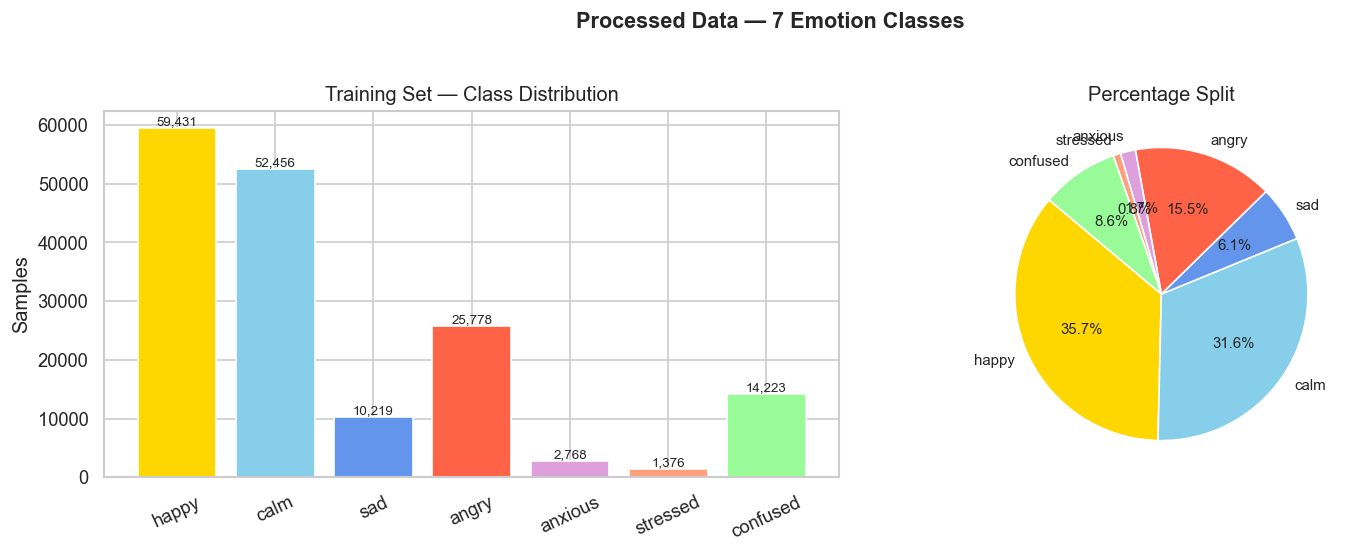

In [10]:
# ── 7a. Class distribution bar chart ──
UI_COLORS = ["#FFD700", "#87CEEB", "#6495ED", "#FF6347", "#DDA0DD", "#FFA07A", "#98FB98"]

counts = train_df["ui_emotion"].value_counts().reindex(UI_LABEL_NAMES)

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Bar chart
bars = axes[0].bar(counts.index, counts.values, color=UI_COLORS, edgecolor="white")
axes[0].set_ylabel("Samples")
axes[0].set_title("Training Set — Class Distribution")
axes[0].bar_label(bars, fmt="{:,.0f}", fontsize=8)
axes[0].tick_params(axis='x', rotation=25)

# Pie chart
axes[1].pie(counts.values, labels=counts.index, autopct="%1.1f%%",
            colors=UI_COLORS, startangle=140, textprops={"fontsize": 9})
axes[1].set_title("Percentage Split")

plt.suptitle("Processed Data — 7 Emotion Classes", fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

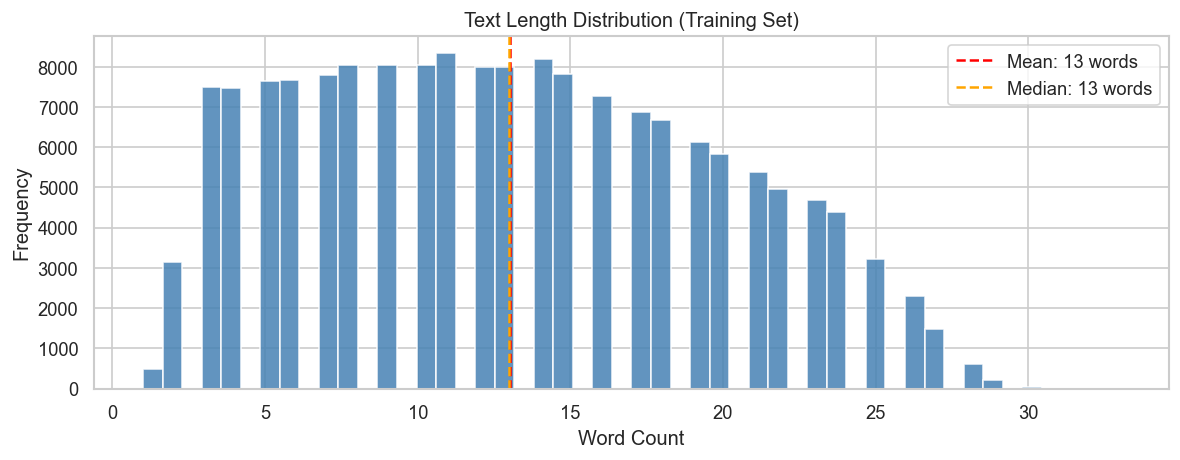

📏 Text Length Stats:
   Mean:   13.0 words
   Median: 13 words
   Max:    33 words
   Min:    1 words


In [11]:
# ── 7b. Text length distribution ──
train_df["word_count"] = train_df["text"].str.split().str.len()

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(train_df["word_count"], bins=50, color="steelblue", edgecolor="white", alpha=0.85)
ax.axvline(train_df["word_count"].mean(), color="red", linestyle="--",
           label=f"Mean: {train_df['word_count'].mean():.0f} words")
ax.axvline(train_df["word_count"].median(), color="orange", linestyle="--",
           label=f"Median: {train_df['word_count'].median():.0f} words")
ax.set_xlabel("Word Count")
ax.set_ylabel("Frequency")
ax.set_title("Text Length Distribution (Training Set)")
ax.legend()
plt.tight_layout()
plt.show()

print(f"📏 Text Length Stats:")
print(f"   Mean:   {train_df['word_count'].mean():.1f} words")
print(f"   Median: {train_df['word_count'].median():.0f} words")
print(f"   Max:    {train_df['word_count'].max()} words")
print(f"   Min:    {train_df['word_count'].min()} words")

In [12]:
# ── 7c. Sample texts per emotion ──
print("📝 Sample Texts (2 per emotion):\n")
for emotion in UI_LABEL_NAMES:
    subset = train_df[train_df["ui_emotion"] == emotion]
    samples = subset["text"].sample(n=min(2, len(subset)), random_state=42)
    print(f"  🔹 {emotion.upper()}")
    for text in samples:
        print(f"     \"{text[:100]}\"")
    print()

📝 Sample Texts (2 per emotion):

  🔹 HAPPY
     "I bet he took down his USA flag to put this one up instead lol"
     "Try not to mix too much. It will get overwhelming and you'll just end up with bad trips."

  🔹 CALM
     "[NAME] must have like 6 rebounds already"
     "The mindset that feminism has instilled them with: entitlement."

  🔹 SAD
     "I hate to be the bearer of bad news but she is more than likely dead and will never get to say goodb"
     "It kills me how much Oklahoma State and Iowa State are able to beat KU but [NAME] and [NAME] just co"

  🔹 ANGRY
     "Man I hate double standards. I love the show but change the word ‘white’ to ‘black’ and it’s suddenl"
     "clearly no one is getting my joke oof."

  🔹 ANXIOUS
     "I just had a panic attack!"
     "I would see a doctor asap and get to a psychiatrist. Hallucinations of any kind are worrisome."

  🔹 STRESSED
     "Sorry misunderstood you! I’m talking about viruses and bacteria that can kill you like the flu etc"
   

In [13]:
# ── 7d. Summary stats ──
biggest  = counts.idxmax()
smallest = counts.idxmin()
ratio    = counts.max() / counts.min()

print("═" * 50)
print("  📊  PROCESSED DATA SUMMARY")
print("═" * 50)
print(f"  Total samples:     {len(df_final):,}")
print(f"  Train / Val:       {len(train_df):,} / {len(val_df):,}")
print(f"  Classes:           {len(UI_LABEL_NAMES)}")
print(f"  Largest class:     {biggest} ({counts.max():,})")
print(f"  Smallest class:    {smallest} ({counts.min():,})")
print(f"  Imbalance ratio:   {ratio:.1f}x")
print(f"  Avg text length:   {train_df['word_count'].mean():.0f} words")
print(f"  Columns saved:     {list(train_check.columns)}")
print("═" * 50)
print("\n✅ Preprocessing complete! Open train_emotion.ipynb to train.")

# Cleanup temp column
train_df.drop(columns=["word_count"], inplace=True, errors="ignore")

══════════════════════════════════════════════════
  📊  PROCESSED DATA SUMMARY
══════════════════════════════════════════════════
  Total samples:     207,814
  Train / Val:       166,251 / 41,563
  Classes:           7
  Largest class:     happy (59,431)
  Smallest class:    stressed (1,376)
  Imbalance ratio:   43.2x
  Avg text length:   13 words
  Columns saved:     ['text', 'ui_emotion', 'label']
══════════════════════════════════════════════════

✅ Preprocessing complete! Open train_emotion.ipynb to train.
